In [33]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup

import os

import folium 
from geopy.geocoders import Nominatim 

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('The above Libraries are imported.')

The above Libraries are imported.


In [34]:
def geo_location(address):
    
    geolocator = Nominatim(user_agent="new_york_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [35]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = ['4JQZIVUHYWUR0LVSA2RS3MTEP1OEU4H5KFF25W0SDNFB2FT1'] # your Foursquare ID
    CLIENT_SECRET = ['RV0TD4ZR5T01VK4MM0MWS33CRH4SPEUQG1LVU4J1GV5OZMXR'] # your Foursquare Secret
    VERSION = '20200721' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    #results = requests.get(url).json()
    #venue_data=results["response"]["groups"][0]['items']
    venu_data = requests.get(url).json()["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [36]:
def get_venue_details(venue_id):
        
    CLIENT_ID = ['4JQZIVUHYWUR0LVSA2RS3MTEP1OEU4H5KFF25W0SDNFB2FT1'] # your Foursquare ID
    CLIENT_SECRET = ['RV0TD4ZR5T01VK4MM0MWS33CRH4SPEUQG1LVU4J1GV5OZMXR'] # your Foursquare Secret
    VERSION = '20200721' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [37]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [38]:
new_york_data=get_new_york_data()

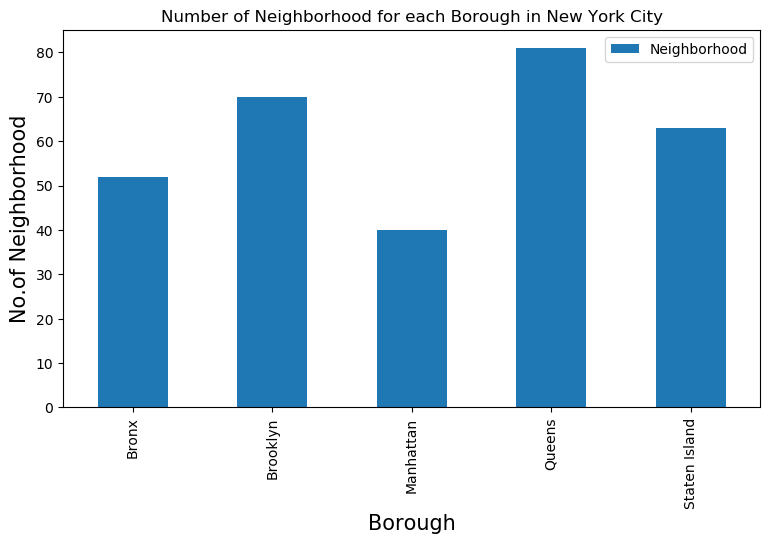

In [41]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [47]:

# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
#    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
   for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

In [46]:
#indian_rest_ny.head()

In [51]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#saves the plot
plt.savefig('Number of Indian Resturants for each Borough in New York City')

In [63]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
legend
plt.legend()
#saves the plot
plt.savefig('Number of Indian Resturants for each Neighborhood in New York City')

In [53]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

In [65]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        #print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        #print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    #print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

In [54]:
indian_rest_stats_ny.head()
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)


In [55]:
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')

In [68]:
#print("Stats_indian_rest_Shape:"indian_rest_stats_ny.shape)
#print("indian_rest_Shape:",indian_rest_ny.shape)

In [56]:
indian_rest_stats_ny_csv

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.6,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,5.8,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.1,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.9,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,5.8,2
5,Bronx,Unionport,0,0,0,0.0,0
6,Brooklyn,Bay Ridge,4b5a4dc8f964a520a2bb28e3,Taj Mahal,38,8.4,26
7,Brooklyn,Brighton Beach,4af0d31bf964a5207ddf21e3,Pak Nasheman,9,7.5,4
8,Brooklyn,Flatbush,52213c4211d295d4c57a607c,Ashoka Grill,8,7.0,14
9,Brooklyn,Flatbush,564d283d498e6e851df79d87,Great Indian Curry,3,6.8,2


*From this cell I'll be using the csv file which was downladed in the above cell,reason being I'm getting the key-error called 'groups' even though I did not exceed my daily limit*

In [57]:
indian_rest_stats_ny_csv['Likes']=indian_rest_stats_ny_csv['Likes'].astype('float64')
indian_rest_stats_ny_csv['Tips']=indian_rest_stats_ny_csv['Tips'].astype('float64')

In [58]:
indian_rest_stats_ny_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 7 columns):
Borough         151 non-null object
Neighborhood    151 non-null object
ID              151 non-null object
Name            151 non-null object
Likes           151 non-null float64
Rating          151 non-null float64
Tips            151 non-null float64
dtypes: float64(3), object(4)
memory usage: 8.3+ KB


***Now we will find the restaurant with max rating***

In [59]:

indian_rest_stats_ny_csv.iloc[indian_rest_stats_ny_csv['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                589
Rating                               9.1
Tips                                 146
Name: 40, dtype: object

***Below is the code to find restaurant with maximum likes***

In [60]:

indian_rest_stats_ny_csv.iloc[indian_rest_stats_ny_csv['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                837
Rating                               8.8
Tips                                 260
Name: 37, dtype: object

***Here are the top 10 neighbours that are listed based on average rating in each neighbourhood***

In [76]:
ny_neighborhood_stats=indian_rest_stats_ny_csv.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Avg_Rating']
ny_neighborhood_stats.sort_values(['Avg_Rating'],ascending=False).head(10)

,Neighborhood,Avg_Rating
12,Civic Center,9.100000
69,Tribeca,9.100000
0,Astoria,9.000000
5,Blissville,9.000000
75,West Village,8.800000
44,Midtown South,8.800000
43,Midtown,8.800000
29,Gramercy,8.733333
25,Fort Greene,8.700000
11,Chelsea,8.700000


***below is the order of boroughs that are listed based on average ratings***

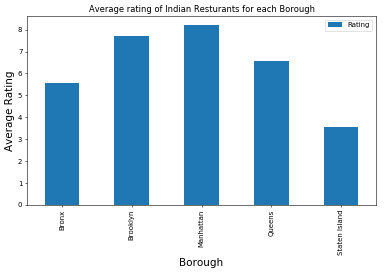

,Borough,Avg_Rating
2,Manhattan,8.210000
1,Brooklyn,7.700000
3,Queens,6.552113
0,Bronx,5.585714
4,Staten Island,3.533333


In [77]:
ny_borough_stats=indian_rest_stats_ny_csv.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Avg_Rating']
ny_borough_stats.sort_values(['Avg_Rating'],ascending=False).head(10)
plt.figure(figsize=(9,5), dpi = 50)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny_csv.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()
ny_borough_stats.sort_values(['Avg_Rating'],ascending=False).head(10)

In [78]:
ny_neighborhood_stats=ny_neighborhood_stats.sort_values(['Avg_Rating'],ascending=False).head(10)

In [79]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [80]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Avg_Rating']]

***below is the list of top 10 Indian Cusine restaurants with their locations lat and longs***

In [82]:
#ny_neighborhood_stats.head(10)
ny_neighborhood_stats.sort_values(['Avg_Rating'],ascending=False).head(10)

,Borough,Neighborhood,Latitude,Longitude,Avg_Rating
0,Manhattan,Civic Center,40.715229,-74.005415,9.100000
1,Manhattan,Tribeca,40.721522,-74.010683,9.100000
2,Queens,Astoria,40.768509,-73.915654,9.000000
3,Queens,Blissville,40.737251,-73.932442,9.000000
4,Manhattan,West Village,40.734434,-74.006180,8.800000
5,Manhattan,Midtown South,40.748510,-73.988713,8.800000
6,Manhattan,Midtown,40.754691,-73.981669,8.800000
7,Manhattan,Gramercy,40.737210,-73.981376,8.733333
8,Brooklyn,Fort Greene,40.688527,-73.972906,8.700000
9,Manhattan,Chelsea,40.744035,-74.003116,8.700000


***Below are the maps with the above locations***

In [83]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [92]:
incidents = folium.map.FeatureGroup()

# loop through the neighborhood and add each to the feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='red',
            fill_opacity=0.7
        )
    )

In [93]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Avg_Rating'].map(str)+')'

In [94]:
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)